<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones básicas en numpy
* Preprocesamiento y exploración de datos, creación de datos sinteticos
* Regresión Lineal Regularizada: _Ridge_ y _Lasso_
* SVM y Kernels
* Más _Cross Validation_


**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ (en caso de ser repositorio privado, invitar como colaborador al usuario de github "avalderr") al correo electrónico del ayudante (*<alvaro.valderrama.13@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF393/578-2019 Tarea2]
* Fecha de entrega y presentaciones: 31 de Mayo. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en dos partes:

[1.](#primero) Clasificación de datos no-linealmente separables  
[2.](#tercero) Regularización para regresión   

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocasiones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.
Si algun modelo se demora demasiado en correr en su maquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, esto puede ser relevante para las maquinas más lentas al momento de realizar exploraciones con _K-folds_ por ejemplo.

### Paquetes a utilizar:

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import KernelPCA

<a id="primero"></a>
## 1. Clasificación de datos no-linealmente separables

Algunos modelos de clasificación buscan implicita o explicitamente separar los datos linealmente, es decir ajustar un hiperplano que separe en 2 subespacios el espacio de las variables, separando ambas clases del _target_. Sin embargo en la mayoría de los casos reales esto resulta imposible. Esto no significa que no podamos ajustar modelos con estos datos o buscar transformaciones que nos permitan utilizarlos. 
    
![Alt Text](http://people.cs.uchicago.edu/~dinoj/manifold/swissroll.gif) 

[comment]: <> (Swiss Roll)

En esta primera parte de la tarea crearemos manualmente un set de datos categóricos no linealmente separables. Este se conformará de puntos en $\mathbb{R}^2$, pertenecientes a una de dos categorías etiquetadas 0 o 1, los cuales se encuentran "anidados". Probaremos distintas aproximaciones lineales y no lineales y compararemos sus desempeños.


### 1.a Creando los datos
La función `do_circles` retorna un conjunto de puntos etiquetados, donde la etiqueta 0 corresponde a puntos siguiendo una circunferencia (con un ruido asociado) y la etiqueta 1 a puntos dentro de esa circunferencia.

Los parámetros de esta función tienen nombres intencionalmente no descriptivos. Analice la función y comente que interpretación puede darle a cada uno de los parámetros con respecto a la influencia que tendrán en el set de datos obtenidos. Si lo estima conveniente, cambie el nombre de los parámetros a nombres más descriptivos.


 Parámetros de la función `do_circles`

- n_dots: número de puntos generados totales del data set (train_set + test_set)
- cf: Número de vueltas a la circunsferencia definida
- ns : desviación estándar del ruido generado para la construcción de los datos  
- scr : radio de la circunsferencia mas pequeña que siguen los datos 

In [81]:
def do_circles(n_dots = 3000, ns = 0.15, scr = 0.3, cf = 1):
    generator = check_random_state(42)
    
    linspace = np.linspace(0, 2*cf*np.pi, n_dots)
    circle_x = np.cos(linspace)
    circle_y = np.sin(linspace)

    inner_circle_x, outer_circle_x, inner_circle_y, outer_circle_y = train_test_split(circle_x, circle_y, test_size = 0.5)
    inner_circle_x , inner_circle_y = inner_circle_x*scr , inner_circle_y*scr 
    
    X = np.vstack((
        np.append(outer_circle_x, inner_circle_x),
        np.append(outer_circle_y, inner_circle_y)
    )).T

    y = np.hstack([
        np.zeros(n_dots // 2, dtype=np.intp),
        np.ones(n_dots // 2, dtype=np.intp)
    ])

    X += generator.normal(scale = ns, size = X.shape)
    return train_test_split(X, y, test_size=0.3, random_state=42)

### 1.b Graficar los datos
Cree una función que grafíque los datos, coloreando distintamente los puntos de cada clase. 
Utilice esta función para verificar gráficamente lo que propuso en la pregunta anterior.

In [82]:
def plot_circles(X_train,y_train,X_test,y_test):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6),sharey=True,sharex=True)
    axs[0].scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1])
    axs[0].scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1])
    axs[1].scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1])
    axs[1].scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1])
    
    axs[0].set_title("Training Set")
    axs[1].set_title("Test Set")
    axs[0].legend(['Clase 0','CLase 1'])
    axs[1].legend(['Clase 0','Clase 1'])
    
    fig.suptitle('Gráfico de dispersión de los datos simulados')
    
    
  
    
    

Primeramente ocupamos la función `do_circles` para simular las 2 muestras de datos y 
luego se grafican con la función creada `plot_circles`


In [91]:
##Simulación de datos
X_train , X_test,y_train,y_test = do_circles()

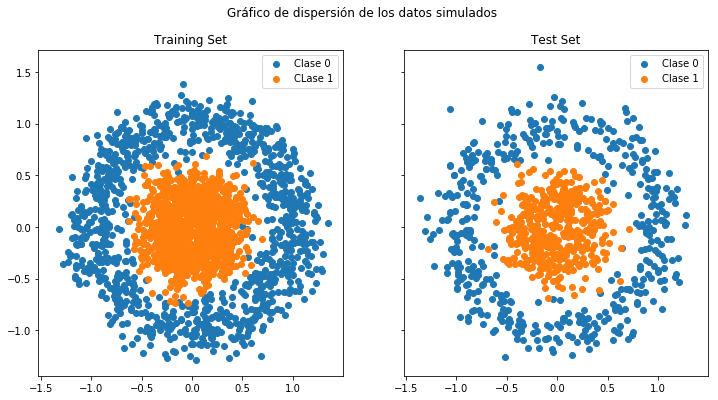

In [92]:
## Gráfica de los datos simulados
plot_circles(X_train,y_train,X_test,y_test)

### 1.c Regresión Logística
​
Realice una regresión logistica para a lo menos 5000 puntos generados con los siguientes parámetros:
* `do_circles(n_dots, 0.2, 0.3, 1)`
* `do_circles(n_dots, 0, 0.3, 1)`
​

Grafique los datos que está ajustando y calcule el _score_ del regresor logístico en cada caso.
¿Qué valor entrega el _score_ del regresor logístico? ¿Le parece un buen desempeño para la tarea a realizar?

**Simulación de los datos**

Con la función `do_circules` generamos las 2 muestras requeridas

In [93]:
X_train_1 , X_test_1,y_train_1,y_test_1 = do_circles(5000, 0.2, 0.3, 1)
X_train_2 , X_test_2,y_train_2,y_test_2 = do_circles(5000, 0, 0.3, 1)

**Simulación 1**

Primero que todo, se grafican los datos generados con ayuda de la función creada `plot_circles` para entender la naturaleza de los datos

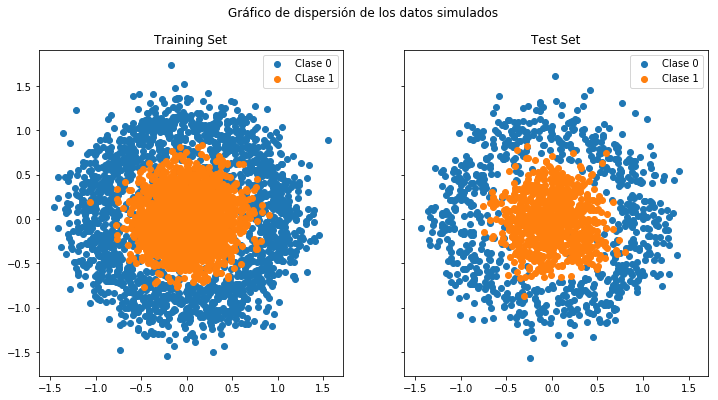

In [94]:
plot_circles(X_train_1,y_train_1,X_test_1,y_test_1)

**Ajuste del Modelo**

Ajustamos el modelo de  $\textbf{Regresión Logística}$ para el primer set de datos `X_train_1,y_train_1,X_test_1,y_test_1` con los parámetros que recibe por defecto, esto es debido a que solo se necesita ver de forma ilustrativa como funciona este clasificador. A priori sabemos que este clasificador no funcionará de manera adecuada, debido a la naturaleza de los datos, estos no son linealmente separables.


In [95]:
### Ajuste del modelo
clf_lr1 = LogisticRegression(solver='lbfgs')
clf_lr1.fit(X_train_1,y_train_1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [96]:
## Predicción y reportes del modelo
pred_lr1 = clf_lr1.predict(X_test_1)
print("Accuracy: "+str( accuracy_score(y_test_1,pred_lr1))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_1,pred_lr1)))


Accuracy: 0.6146666666666667

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       0.76      0.36      0.49       768
           1       0.57      0.88      0.69       732

   micro avg       0.61      0.61      0.61      1500
   macro avg       0.66      0.62      0.59      1500
weighted avg       0.67      0.61      0.59      1500



**Simulación 2**

Procedemos de la misma forma que en la simulación 1

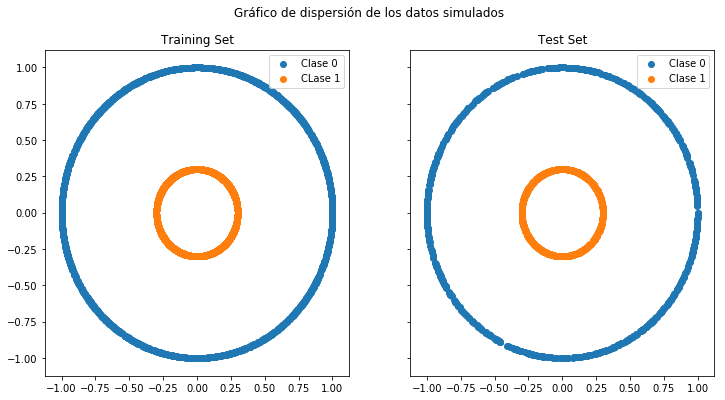

In [97]:
plot_circles(X_train_2,y_train_2,X_test_2,y_test_2)

Se puede ver claramente que este set de datos define perfectamente 2 circunsferencias de radio 0.3 y 1, esto se debe a que estos datos no poseen ruido aleatorio

**Ajuste del Modelo**

Ajustamos el modelo de  $\textbf{Regresión Logística}$ para el segundo set de datos `X_train_2,y_train_2,X_test_2,y_test_2` con los parámetros que recibe por defecto, esto es debido a que solo necesitar ver de forma ilustrativa como funciona este clasificador. A priori sabemos que este clasificador no funcionará de manera adecuada, debido a la naturaleza de los datos, estos no son linealmente separables.

In [98]:
clf_lr2 = LogisticRegression(solver='lbfgs')
clf_lr2.fit(X_train_2,y_train_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
pred_lr2 = clf_lr2.predict(X_test_2)
print("Accuracy: "+str( accuracy_score(y_test_2,pred_lr2))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_2,pred_lr2)))

Accuracy: 0.6773333333333333

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       1.00      0.37      0.54       768
           1       0.60      1.00      0.75       732

   micro avg       0.68      0.68      0.68      1500
   macro avg       0.80      0.68      0.65      1500
weighted avg       0.81      0.68      0.64      1500



**Conclusiones**

 El score del modelo de Regresión Logistica es bastante deficiente, ademas de los distintos indicadores (recall, f1, etc), lo que nos indica a que se debe proceder de diferente manera, ya sea con diferentes clasificadores y/o la transformación de los datos.

### 1.d Graficos
Para entender mejor lo que está ocurriendo con el clasificador en cada uno de los casos, grafícaremos los datos clasificados y la frontera de desición ajustada por el modelo. Para esto complete la función siguiente y luego utilícela para ambos modelos y conjuntos de datos ajustados en la pregunta anterior. 

¿Qué puede concluir luego de estas visualizaciones? ¿Es posible mejorar el desempeño de algún clasificador lineal sin hacer una transformación de los datos? ¿Qué ocurre con el clasificador si disminuimos el ruido, mejora realmente su desempeño? 

In [100]:
def plot_classifier(classifier, X_train, Y_train, X_test, Y_test, train_or_test='test'):
   
    plt.figure(figsize=(12, 8))
    axis = plt.axes()
    if train_or_test == 'train':
        axis.scatter(X_train[Y_train==0][:,0], X_train[Y_train==0][:,1],cmap=plt.cm.tab10)
        axis.scatter(X_train[Y_train==1][:,0], X_train[Y_train==1][:,1],cmap=plt.cm.tab10)      
       
        # Scatter train points (axis.scatter(. . .)) 
    elif train_or_test == 'test':
        axis.scatter(X_test[Y_test==0][:,0], X_test[Y_test==0][:,1])
        axis.scatter(X_test[Y_test==1][:,0], X_test[Y_test==1][:,1])
        
        # Scatter test points
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
    Z = classifier.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
    Z = Z.reshape(XX.shape) # for consistency
    Zplot = Z > 0.5 # to separate both classes
    axis.pcolormesh(XX, YY, Zplot, cmap='YlGn',alpha=0.3)
    axis.contourf(XX, YY, Zplot, alpha=0.2, colors=["r"], linestyles=["-"], levels=[0.5,1])
    plt.legend(['Clase 0','Clase 1'])
   
    plt.text(-1.9,1.7,"Predicciones:")
    plt.text(-1.9,1.5,"Clase 0:Región Clara") 
    plt.text(-1.9,1.3,"Clase 1:Región Sombreada") 
    plt.title("Frontera de decisión de las clases del clasificador")
    plt.show()

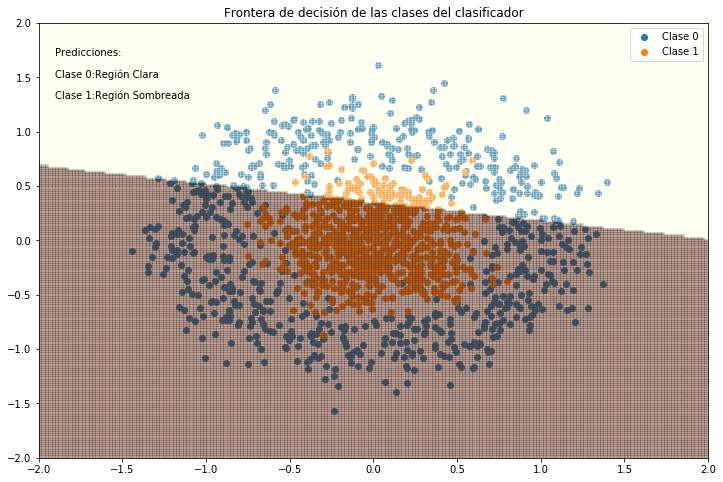

In [101]:
plot_classifier(clf_lr1,X_train_1,y_train_1,X_test_1,y_test_1,train_or_test='test')

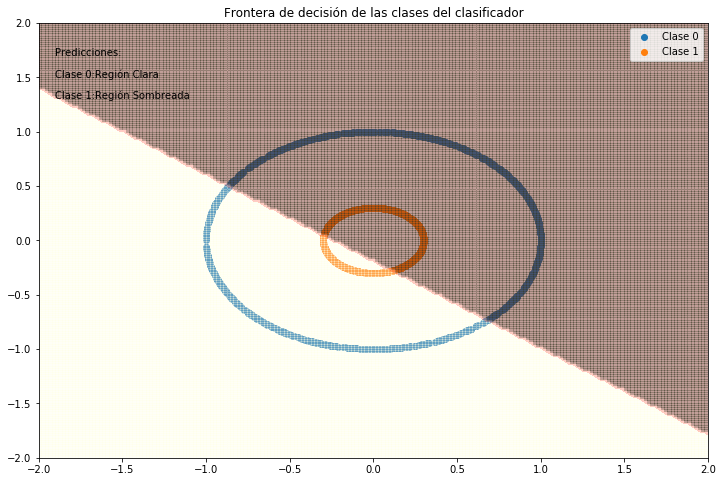

In [16]:
plot_classifier(clf_lr2,X_train_2,y_train_2,X_test_2,y_test_2,train_or_test='test')

**Conclusiones**

Como mencionamos anteriormente, al ser los datos no linealmente separables, nos resultará imposible mejorar el rendimiento de estos clasificadores, que poseen un rendimiento bastante deficiente considerando la medida f1 y el Accuracy.

Si disminuimos el ruido del set de datos el desempeño del clasificador mejorar sutilmente, sin embargo, rara vez nos encontramos con este tipo de datos. 

Para las siguientes preguntas nos enfocaremos **solo en la versión con ruido de los datos** pues en la práctica no existen datos sin ruido. Probaremos algunos métodos no lineales para ver que tanto logramos mejorar el desempeño en nuestros datos. 

### 1.e SVM

Entrene un clasificador SVM con los datos con ruido. ¿Qué forma tiene la frontera de decisión esta vez? 

¿Mejoran los resultados al alejarse de los metodos puramente lineales? Comente sobre el desempeño del modelo y su sensibilidad a los parámetros `C` y `gamma`, explorando como cambia la frontera de desición al variar estos parámetros. 

##### Entrenamiento modelo SVM

Para esta preguta, nos apoyaremos en la función `GridSearchCV()` que recibe como entrada el modelo a utilizar, una grilla de posibles parámetros de modelo y el número de fold para el coss validation y nos entrega los mejores parámetros para dicho modelo, esto nos simplificará enormemente nuestro código.

In [102]:
### Generamos una grilla tipo diccionario de los posibles parametros que admite la funcion SVC
parameters = [
    {
        'kernel': ['rbf'],
        'gamma' : [1e-4,1e-3,1e-2, 0.1, 0.2, 0.5],
        'C': [1,10,100,1000]
    },
    {
        'kernel':["linear"],
        'C':[1,10,100,1000]
    }
]

In [103]:
clf_svm = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid=parameters, cv=5)
clf_svm.fit(X_train_1,y_train_1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [104]:
print('Los mejores parámetros del modelo para el set de datos son: \n')
bp_svm = clf_svm.best_params_
for i in bp_svm:
    print('  '+ str(i)+': '+str(bp_svm[i]))

Los mejores parámetros del modelo para el set de datos son: 

  C: 1
  gamma: 0.5
  kernel: rbf


In [105]:
pred_svm = clf_svm.predict(X_test_1)

In [106]:
print("Accuracy: "+str( accuracy_score(y_test_1,pred_svm))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_1,pred_svm)))

Accuracy: 0.958

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       768
           1       0.95      0.96      0.96       732

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



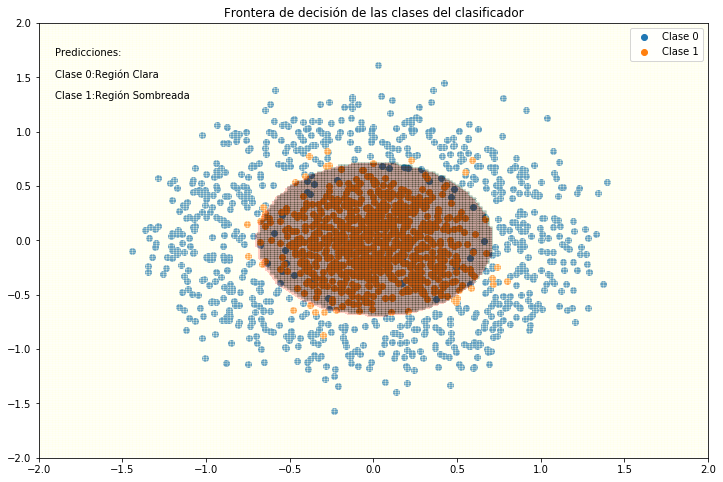

In [107]:
plot_classifier(clf_svm,X_train_1,y_train_1,X_test_1,y_test_1,train_or_test='test')

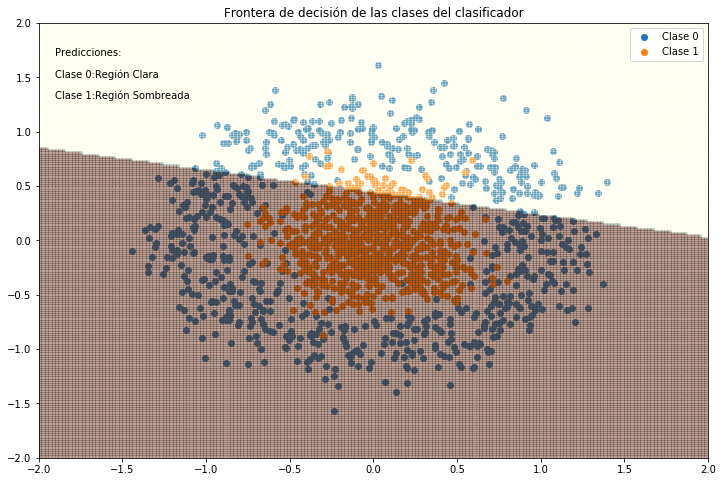

In [156]:
clf_svm_lin = SVC(kernel='linear')
clf_svm_lin.fit(X_train_1,y_train_1)
pred_svm_lin = clf_svm_lin.predict(X_test_1)
plot_classifier(clf_svm_lin,X_train_1,y_train_1,X_test_1,y_test_1,train_or_test='test')

In [110]:
## Comportamiento del modelo SVM frente al cambio de los parámetros
means = clf_svm.cv_results_['mean_test_score']
stds = clf_svm.cv_results_['std_test_score']
params = clf_svm.cv_results_['params']
for m, s, p in zip(means, stds, params):
    print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))

0.505 (+/-0.001) para {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.505 (+/-0.001) para {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.533 (+/-0.071) para {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.950 (+/-0.009) para {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.951 (+/-0.007) para {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.951 (+/-0.010) para {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.505 (+/-0.001) para {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.518 (+/-0.052) para {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.907 (+/-0.010) para {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.950 (+/-0.008) para {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.951 (+/-0.010) para {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.951 (+/-0.011) para {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.517 (+/-0.048) para {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.594 (+/-0.141) para {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.950 (+/-0.008) para {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.950 (+/-0.009) para {'C': 100, 'gamma'

**Conclusiones**


Podemos observar claramente que el rendimiento del clasificador encontrado mejora considerablemente respecto al modelo anterior, esto se debe principalmente al uso de los diferentes parámetros que este modelo admite, en los que destacan:
- Tipo de Kernel (Radial)
- Valores de 'gamma'  
- Valores de 'C' 

A modo de comparación, se ajustó además un modelo de SVM con kernel lineal para notar las diferencias al utilizar  Kernel Radial  y además ver las similitudes del modelo de SVM (Lineal) con los resultados obtenidos por el modelo de regresión logística.


Respecto al gráfico, con los parámetros elegido, vemos que la frontera de decisión adopta una forma de elipse que se adecua de mejor manera a los datos, esto tiene sentido debido a que conocemos como están generados estos datos.

### 1.f KNN
Pruebe ahora con otro método no lineal, _K nearest neighbors_ o KNN. Discuta sus resultados y la frontera de desición que encuentra el modelo. 

Realice un _Cross Validation_ sobre el parámetro `n_neighbors` o `p` (o ambos usando un mallado) y comente si mejoran significativamente los resultados. Puede apoyarse de los códigos de la tarea 1 para realizar el _Cross Validation_.
¿Qué representan estos parámetros para el metodo?

**Solución:**

De la misma forma que encontramos los parámetros para el modelo de Máquina de Soporte Vectorial, buscamos los parámetros para el modelo de K Nearest Neighbor, ocupando la funcion `GridSearchCV` 

In [111]:
### Generamos una grilla de los posibles parametros que admite la funcion SVC
parameters_knn = [
    {
        'n_neighbors': [2,3,4,5,6,7,8,9,10,11],
        'p' : [1,2,3,4]
        

    }   
]

In [112]:
clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameters_knn, cv=5)
clf_knn.fit(X_train_1,y_train_1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'p': [1, 2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
print('Los mejores parámetros del modelo son: \n')
bp_knn = clf_knn.best_params_
for i in bp_knn:
    print('  '+ str(i)+': '+str(bp_knn[i]))


Los mejores parámetros del modelo son: 

  n_neighbors: 10
  p: 4


In [117]:
pred_knn = clf_knn.predict(X_test_1)

In [118]:
print("Accuracy: "+str( accuracy_score(y_test_1,pred_knn))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_1,pred_knn)))

Accuracy: 0.9566666666666667

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       768
           1       0.96      0.95      0.96       732

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [119]:
means = clf_knn.cv_results_['mean_test_score']
stds = clf_knn.cv_results_['std_test_score']
params = clf_knn.cv_results_['params']
for m, s, p in zip(means, stds, params):
    print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))

0.930 (+/-0.015) para {'n_neighbors': 2, 'p': 1}
0.931 (+/-0.016) para {'n_neighbors': 2, 'p': 2}
0.931 (+/-0.018) para {'n_neighbors': 2, 'p': 3}
0.931 (+/-0.017) para {'n_neighbors': 2, 'p': 4}
0.943 (+/-0.010) para {'n_neighbors': 3, 'p': 1}
0.940 (+/-0.011) para {'n_neighbors': 3, 'p': 2}
0.940 (+/-0.015) para {'n_neighbors': 3, 'p': 3}
0.940 (+/-0.015) para {'n_neighbors': 3, 'p': 4}
0.945 (+/-0.008) para {'n_neighbors': 4, 'p': 1}
0.943 (+/-0.007) para {'n_neighbors': 4, 'p': 2}
0.943 (+/-0.008) para {'n_neighbors': 4, 'p': 3}
0.943 (+/-0.006) para {'n_neighbors': 4, 'p': 4}
0.949 (+/-0.004) para {'n_neighbors': 5, 'p': 1}
0.949 (+/-0.002) para {'n_neighbors': 5, 'p': 2}
0.948 (+/-0.004) para {'n_neighbors': 5, 'p': 3}
0.948 (+/-0.006) para {'n_neighbors': 5, 'p': 4}
0.947 (+/-0.004) para {'n_neighbors': 6, 'p': 1}
0.947 (+/-0.007) para {'n_neighbors': 6, 'p': 2}
0.947 (+/-0.008) para {'n_neighbors': 6, 'p': 3}
0.947 (+/-0.008) para {'n_neighbors': 6, 'p': 4}
0.946 (+/-0.006) par

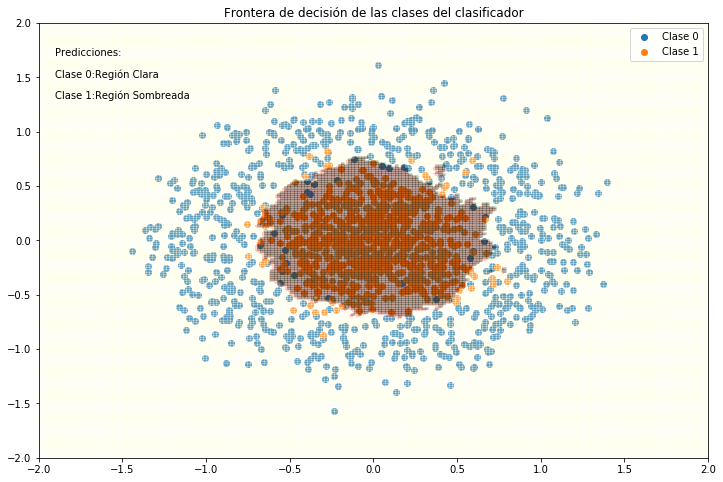

In [120]:
plot_classifier(clf_knn,X_train_1,y_train_1,X_test_1,y_test_1,train_or_test='test')


**Conclusiones**

Se obtienen resultados similares a los obtenidos por la SVM radial, los cuales son bastnte adecuados. 

La forma de la frontera de decisión adopta una figura cuasi elíptica, pero a diferencia de la frontera de la SVM, posee los bordes irregurales, que intentan acomodarse de mejor forma a los datos

Las parametros que se tomaron en consideración tienen la siguiente representación:

- n_neighbors : Número de vecinos que se consideran para la clasificación
- p : Distancia que se considera para el modelo $L^p$

### 1.g
Del mejor modelo obtenido en el punto anterior, grafíque los datos de test coloreando de manera difente los puntos mal clasificados por su modelo. ¿Por qué el modelo no logra clasificar bien estos puntos? ¿Qué habría ocurrido si estuvieramos utilizando los datos sin ruido?

- Conjunto de test : X_test_1 , y_test_1

- Prediccion : clf_knn

In [121]:
indices = [y_test_1[i]==pred_knn[i] for i in range(len(y_test_1))]
indices_dif = [y_test_1[i]!=pred_knn[i] for i in range(len(y_test_1))]

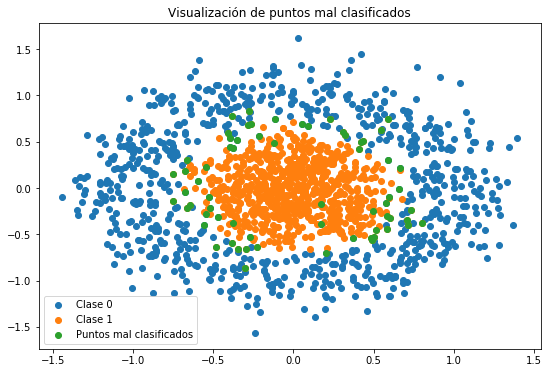

In [122]:
#plt.scatter(X_test_1[indices][:,0],X_test_1[indices][:,1])
plt.figure(figsize=(9,6))
plt.scatter(X_test_1[y_test_1==0][:,0], X_test_1[y_test_1==0][:,1])
plt.scatter(X_test_1[y_test_1==1][:,0], X_test_1[y_test_1==1][:,1])
plt.scatter(X_test_1[indices_dif][:,0],X_test_1[indices_dif][:,1])
plt.legend(['Clase 0','Clase 1','Puntos mal clasificados'])
plt.title("Visualización de puntos mal clasificados")
plt.show()

**Conclusión**

El motivo por el cual el modelo no puede clasificar bien estos puntos se puede deber a diversas razones:

- Datos outliers

- Ruido inherente en los datos que están en la naturaleza: 
   - Error de Digitación
   - Fallas en instrumento de medida
   - etc
    


Si tuvieramos datos sin ruido la clasificación sería perfecta, como lo vemos en el siguiente gráfico.

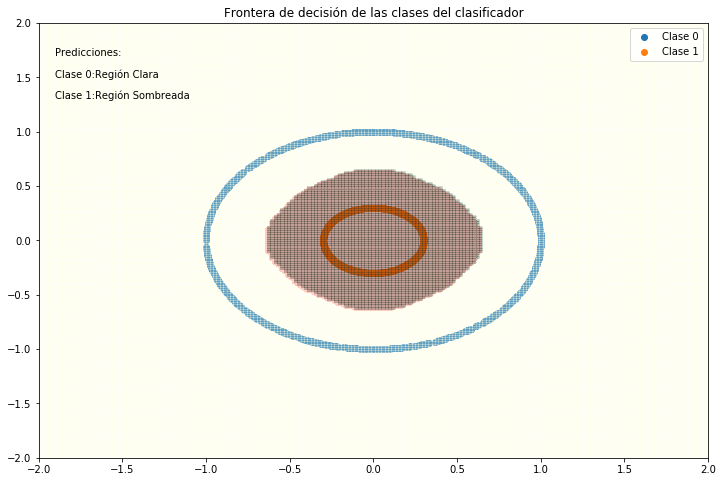

In [35]:
clf_knn_2 = GridSearchCV(KNeighborsClassifier(), param_grid=parameters_knn, cv=5)
clf_knn_2.fit(X_train_2,y_train_2)
pred_knn_2 = clf_knn_2.predict(X_test_2)
plot_classifier(clf_knn_2,X_train_2,y_train_2,X_test_2,y_test_2,train_or_test='test')

In [123]:
print("Accuracy: "+str( accuracy_score(y_test_2,pred_knn_2))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_2,pred_knn_2)))

Accuracy: 1.0

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       768
           1       1.00      1.00      1.00       732

   micro avg       1.00      1.00      1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



### 1.h Metodo Kernel
Utilizaremos Kernel Gaussiano para preprocesar los datos, pasando implícitamente por un espacio altamente dimensional (más especificamente por un _mainfold_ de un espacio infinito dimensional), obteniendo una representación lo más linealmente separable posible. 

Ajuste el kernel y transforme los datos. Grafique los puntos transformados y comente que realiza el modelo. Varie luego el valor de `gamma` para tratar de entender qué influencia tiene sobre la separabilidad de los puntos transformados. ¿Le parece un buen método para este problema? 

Usando algún valor de `gamma` que le parezca adecuado, ajuste un modelo de regresión logística sobre los datos transformados. Mejora el desempeño del modelo respecto a la versión original? ¿Se logra aumentar la separabilidad lineal de los datos efectivamente? Apoyese de gráficos y métricas adecuados. 

In [124]:
ker_1 = KernelPCA(2,kernel='rbf',gamma=1)
ker_1.fit(X_train_1)
x_train_rbf_1 = ker_1.transform(X_train_1)
x_test_rbf_1 = ker_1.transform(X_test_1)

ker_2 = KernelPCA(2,kernel='rbf',gamma=2)
ker_2.fit(X_train_1)
x_train_rbf_2 = ker_2.transform(X_train_1)
x_test_rbf_2 = ker_2.transform(X_test_1)

ker_3 = KernelPCA(2,kernel='rbf',gamma=3)
ker_3.fit(X_train_1)
x_train_rbf_3 = ker_3.transform(X_train_1)
x_test_rbf_3 = ker_3.transform(X_test_1)

ker_4 = KernelPCA(2,kernel='rbf',gamma=4)
ker_4.fit(X_train_1)
x_train_rbf_4 = ker_4.transform(X_train_1)
x_test_rbf_4 = ker_4.transform(X_test_1)

Gráfico para 'gamma'=1 


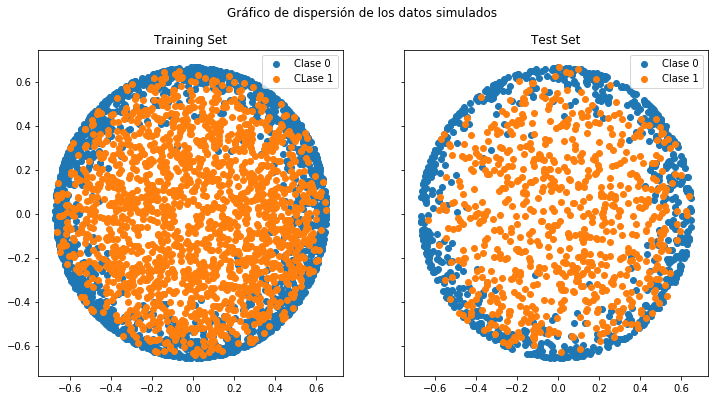

In [125]:
print("Gráfico para 'gamma'=1 ")
plot_circles(x_train_rbf_1,y_train_1,x_test_rbf_1,y_test_1)

Gráfico para 'gamma'=2 


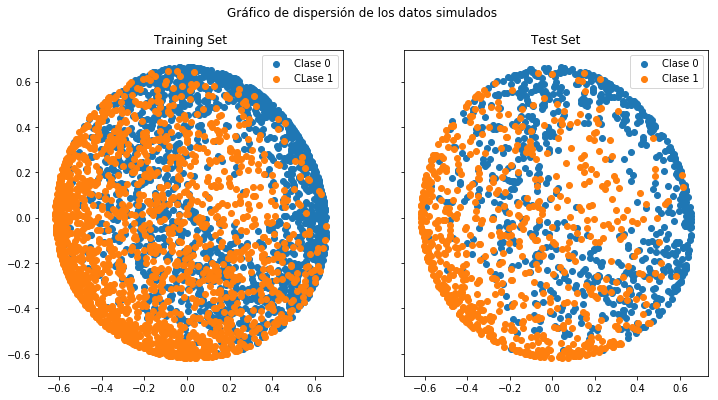

In [126]:
print("Gráfico para 'gamma'=2 ")
plot_circles(x_train_rbf_2,y_train_1,x_test_rbf_2,y_test_1)

Gráfico para 'gamma'=3 


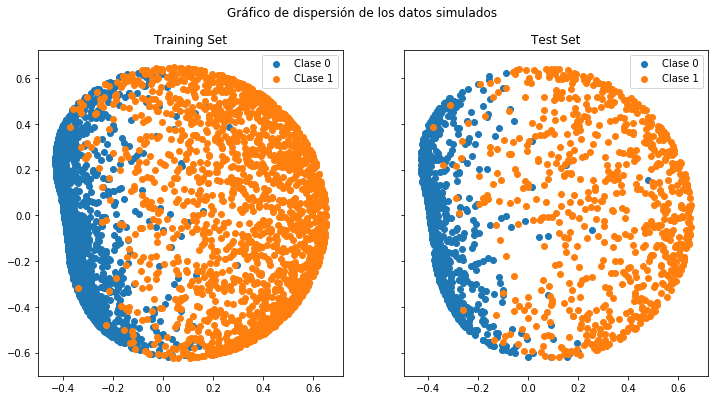

In [127]:
print("Gráfico para 'gamma'=3 ")
plot_circles(x_train_rbf_3,y_train_1,x_test_rbf_3,y_test_1)

Gráfico para 'gamma'=4 


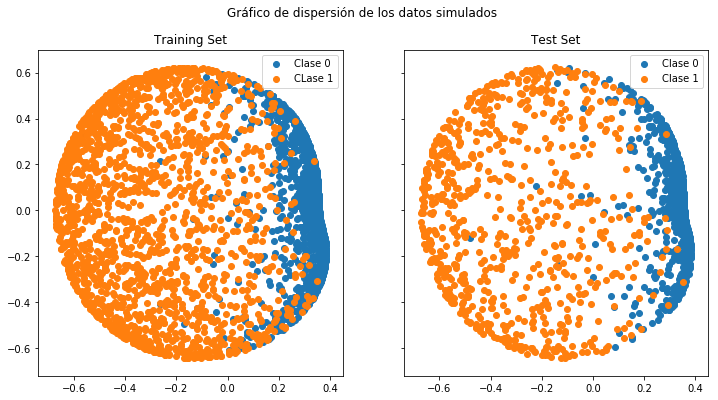

In [128]:
print("Gráfico para 'gamma'=4 ")
plot_circles(x_train_rbf_4,y_train_1,x_test_rbf_4,y_test_1)

Está transformación, se ve bastante adecuada ya que graficamente podemos observar que las clases se van concentrando en lados contrarios, por lo que un clasificador lineal podría funcionar de manera efectiva.

**Ajustando modelo de regresión logística**

In [129]:
clf_lr = LogisticRegression(solver='lbfgs')
clf_lr.fit(x_train_rbf_4,y_train_1)
pred_lr = clf_lr.predict(x_test_rbf)

In [130]:
print("Accuracy: "+str( accuracy_score(y_test_1,pred_lr))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_1,pred_lr)))

Accuracy: 0.892

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       768
           1       0.86      0.93      0.89       732

   micro avg       0.89      0.89      0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



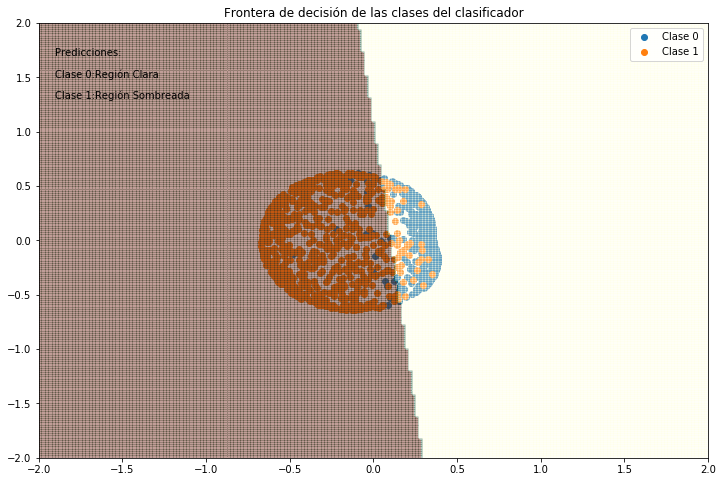

In [131]:
plot_classifier(clf_lr,x_train_rbf_4,y_train_1,x_test_rbf_4,y_test_1,train_or_test='test')

**Conclusión**

Podemos apreciar que el desempeño del  Modelo de Regresión Logistica aumenta considerablemente, llegando a los niveles de los modelos anteriores ( KNN y SVM radial). Lo fundamental  fue el preprocesamiento de lo datos que nos permitió separar linealmente nuestros datos, como podemos apreciar en el gráfico.

### 1.i Manualmente
Como nosotros conocemos como se generaron los datos tenemos una ventaja sobre los modelos. Genere una transformación de los datos que estime conveniente para obtener datos linealmente separables. Puede aumentar o disminuir la dimensión a gusto, por ejemplo puede realizar algo del estilo $(x,y)\longrightarrow (x+y)$, ó $(x,y)\longrightarrow (x,y,x+y,x-y)$. Apoyese de las carácteristicas geométricas del conjunto de datos y justifique sus elecciónes con gráficos adecuados. 

Luego entrene un regresor logístico sobre sus datos transformados y comente sobre la utilidad de conocer cómo se generaron los datos. Grafíque los datos transformados o alguna proyección de ellos junto con la frontera de desición y comente sobre lo que realiza su transformación.

**Solución:**

Al conocer como fueron generados los datos, podemos realizar algún tipo de transformaciones que nos ayuden a que los datos logren ser linealmente separables.



Consideremos la siguiente transformación:

\begin{align}
K:\mathbb{R}^2 \longrightarrow &\mathbb{R}^3 \\
(x,y) \longrightarrow &K(x,y)=(x,y,x^2+y^2)
\end{align}

Luego esta transformación la aplicamos a nuestros datos de entrada,sabiendo que :

- $x_1 = R \cdot Cos(\theta)$ 
- $x_2 = R \cdot Sen(\theta)$

lo que nos lleva a que:

\begin{align}
x_1^2 + x_2^2 &= R^2\cdot Cos^2(\theta)+R^2\cdot Sin^2(\theta) \\
&=R^2\left(Cos^2(\theta)+Sin^2(\theta)\right) \\
&=R^2
\end{align}




In [132]:
z_1_train = X_train_1[:,0]
z_2_train = X_train_1[:,1]
z_3_train = z_1_train**2+z_2_train**2

Z_train = np.vstack((
        z_1_train,z_2_train,z_3_train
    )).T


z_1_test = X_test_1[:,0]
z_2_test = X_test_1[:,1]
z_3_test = z_1_test**2+z_2_test**2

Z_test = np.vstack((
        z_1_test,z_2_test,z_3_test
    )).T

In [133]:
clf_lr = LogisticRegression(solver='lbfgs')
clf_lr.fit(Z_train,y_train_1)
pred_lr = clf_lr.predict(Z_test)

In [134]:
print("Accuracy: "+str( accuracy_score(y_test_1,pred_lr))+"\n")
print("Reporte de Clasificación: \n \n"+str(classification_report(y_test_1,pred_lr)))

Accuracy: 0.9586666666666667

Reporte de Clasificación: 
 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       768
           1       0.95      0.97      0.96       732

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [152]:
u = z_1_train.reshape(-1,1)
v = z_2_train.reshape(-1,1)
w = z_3_train.reshape(-1,1)

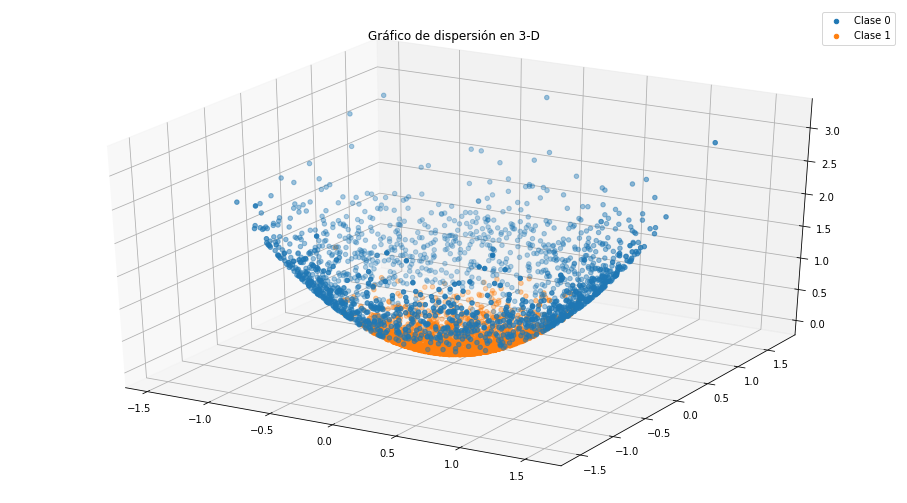

In [153]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Creamos la figura
fig = plt.figure(figsize=(16,9))

# Agrrgamos un plano 3D
ax1 = fig.add_subplot(111,projection='3d')

# Datos en array bi-dimensional
x = u[y_train_1==0]
y = v[y_train_1==0]
z = w[y_train_1==0]

x2 = u[y_train_1==1]
y2 = v[y_train_1==1]
z2 = w[y_train_1==1]


# plot_wireframe nos permite agregar los datos x, y, z. Por ello 3D
# Es necesario que los datos esten contenidos en un array bi-dimensional
ax1.scatter3D(x, y, z)
ax1.scatter3D(x2,y2,z2)
plt.legend(['Clase 0','Clase 1'])
# Mostramos el gráfico
plt.title("Gráfico de dispersión en 3-D")
plt.show()

**Comentario:** Observamos que los datos de la clase 1 se encuentran en el piso del paraboloide, encontrando la separabilidad lineal con respecto a la clase 0, esto se debe a que se utilizó el radio como la variable a separar